<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/BERT_fine_tuning_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning project assignment

**Task 6:** BERT fine-tuning for classification

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

**Tutorial content and Adaptations**

The tutorial data set GLUE MRPC is classifying sentence pairs.
In the assignment, please use a data set to classify single sentences.
For example, GLUE itself has such data sets, like COLA or SST2, which are provided as TFDS.

You need to adapt the data preprocessing to be used for this task.
The suggested building of the model with bert.bert_models.classifier_model() is a very high-level abstraction.

Instead of using this function, take a pre-trained BERT encoder and connect it to a classification model yourself.
This way, you can understand better how the information flow from input through encoder to classifier.

With those adaptations, follow the tutorial and fine-tune a pre-trained BERT on classification.
In addition to the evaluation based on training/evaluation set, run queries you made yourself to test generalization of the classifier.

**Comment:** I think there is a bug in result = tf.argmax(result).numpy() - the argmax should be over axis=1. (try processing more than 2 sequences)

**Yes, it should have axis = 1 as an argument**

Here are a few questions for you to check how well you understood the tutorial.
Please answer them (briefly) in your solution!

- What is the tutorial classifying when using the GLUE MRPC data set?

**Whether two sentences are semantically similar or not**

- In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model. Is this necessary for the data set single sentence classification?

**Theoretically both of them might not be necessary especially for single sentence as encoder can learn where actual sequence starts and padding begins instead of input mask. For input word ids, since we have only one single sentence it is waste to again differentiate inside the sequence. But practically, when tried out on tensorflow, it gave an error due to encoder architecture, Hence we added both of them during our pretraining. Maybe its possible in other libraries**

- How does the tokenization in BERT differ from the one in the previous Task 5?

**Sequence is split by whitespace, punctuations and then BPT is used to further split a single word to multiple managable pieces, unlike NMT where each word is a token hence should be present in vocab.**

- What is a [CLS] token and what is it used for?

**[CLS] Token denotes start of the sentence or sequence. It could be used for classification too at the linear layer**

- Which part of the BERT encoding is used for the classification?

**[CLS] token is used for classification, although i bieleive you can modify the architecture to use any token embedding as encoder can see both past and future and there are 12 layers + multiheads so lots of context would be encoded in the embeddings anyway. I saw a Lambda layer which makes use of particular tokens in the sequence of last attention head(photo of this is present inside the code). this lambda l;ayer could theoretically be changed.**

- Does your answer match the output shape of the encoder?

**Shape of the my answer doesn't match shape of output of encoder as encoder just outputs embeddings. On the other hand, Classifiers output matched my answer.** 

- Are the BERT encoder weights also fine-tuned to the task?

**Yes, weights of encoder are finetuned while pretraining. But i suppose we can freeze some bottom layers and include only some top layers in pretraining. Saw this techniques for other libraries.**


**Tasks to be done**

**MRPC**

- Learn about MRPC and Run the tutorial as is first and check what it is classifying(answer to 1st question) 
- note down how the tokenization is done(question 3) ?
- whether bert weights are fine tuned during training or not(question 7) . Plot weight distributions if possible(before vs after)?
- Check about the binary tensors that are fed along with data and what happens without them(question 2)?

**Connecting our own pretrained BERT**
- After running above experiments connect a pretrained bert model to classifier and make it work on MRPC.

**Done in COLA**

- See how the information is being exchanged between BERT and classifier?

**Pooled output or single embedding is taken and used for classification**

**SST2**

- Change to SST2 as we have larger data than COLA and do sentiment classification. Build the system such that you can give your own text later?
- Create tricky movie reviews that are difficult for computers and check for generalization.?

**Generalized OK, but was not great. Cannot clssify some sarcastic movie reviews.**

- Check about the binary tensors that are fed along with data and what happens without them(question 2)?

**Checked and wrote up in COLA summary.**


**COLA**

- **Build manual Encoder + classifier for COLA and test it out**





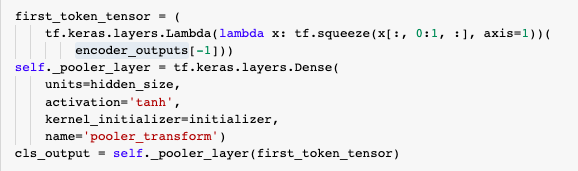

**It seems like The lambda layer is extracting information from last encoder layer output. Also it seems like it being picked from a single token 0:1 slicing.**

**The pooler layer is just a dense layer with Tanh activation on embedding from lambda layer.** **bold text**

**Summary**



In [1]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly


     |████████████████████████████████| 323.7MB 48kB/s 
     |████████████████████████████████| 460kB 55.2MB/s 
     |████████████████████████████████| 6.7MB 54.7MB/s 
     |████████████████████████████████| 880kB 4.7MB/s 
     |████████████████████████████████| 174kB 23.6MB/s 
     |████████████████████████████████| 1.1MB 20.2MB/s 
     |████████████████████████████████| 358kB 27.8MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 36.4MB 84kB/s 
     |████████████████████████████████| 296kB 52.4MB/s 


In [2]:
!pip install tf-nightly

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow.keras.layers.experimental

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import official.nlp.bert.bert_models
# Load the required submodules
import official.nlp.optimization

import official.nlp.bert.configs

import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
import official.nlp.bert.bert_models
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization

2.4.0-dev20200731


# Vanilla MRPC load - For testing (Used higher level abstraction)

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteOY6K74/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteOY6K74/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteOY6K74/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [ ]:

list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


glue_train, glue_test and validation contains keys index, label, sentence1, sentence2 and a list of values attached to each keys.
There are around 3.6 k values

In [ ]:
glue_train.keys()

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])

In [ ]:
glue_train["idx"]
glue_train["sentence2"]

<tf.Tensor: shape=(3668,), dtype=string, numpy=
array([b'The rovers act as robotic geologists , moving on six wheels .',
       b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold .",
       b'Spider-Man , rated PG-13 , snatched $ 114.7 million in its first weekend and went on to take in $ 403.7 million .',
       ...,
       b'Stack testified that he was not asked to do any work for Triumph until June 1999 , after a grand jury investigating Silvester subpoenaed Triumph .',
       b'The rock was first observed by the Lincoln Near Earth Asteroid Research Program , also known as LINEAR .',
       b'U.S. Attorney Jeffrey Collins also said two of his assistants will consult with state police during the investigation and determine if any federal laws were broken .'],
      dtype=object)>

We need to use the same tokenizer as we had used during training(May cause probems for multilingual corpus)


- https://juditacs.github.io/2019/02/19/bert-tokenization-stats.html

All tokens are being converted to lowercase and also split along the punctuations.
Greedy longest match algorithm is used(check Class and methods wordpiecetokenizer and method tokenize).

Non-word-initial units are prefixed with ## as a continuation symbol 

can take upto 400 chars pr word --> wordpiece toeknizer, Uses [UNK] token for unknown

whitespace tokenizer consists of tabs, newline and carriage return too

Unused tokens should be replaced by our own vocab: https://stackoverflow.com/questions/62452271/understanding-bert-vocab-unusedxxx-tokens

keys are the tokens or the cutoff tokens and values are just the counter value



In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
start = 500
counter = 0
end = 510
for key,val in tokenizer.vocab.items():
  if(counter > start and counter < end):
    print("key: {} | value: {}".format(key,val))
  counter = counter + 1
  if(counter  > end):
    break;

key: [unused496] | value: 501
key: [unused497] | value: 502
key: [unused498] | value: 503
key: [unused499] | value: 504
key: [unused500] | value: 505
key: [unused501] | value: 506
key: [unused502] | value: 507
key: [unused503] | value: 508
key: [unused504] | value: 509


In [ ]:
start = 1000
counter = 0
end = 1005
for key,val in tokenizer.vocab.items():
  if(counter > start and counter < end):
    print("key: {} | value: {}".format(key,val))
  counter = counter + 1
  if(counter  > end):
    break;

key: # | value: 1001
key: $ | value: 1002
key: % | value: 1003
key: & | value: 1004


In [ ]:
start = 5000
counter = 0
end = 5020
for key,val in tokenizer.vocab.items():
  if(counter > start and counter < end):
    print("key: {} | value: {}".format(key,val))
  counter = counter + 1
  if(counter  > end):
    break;

key: lap | value: 5001
key: survey | value: 5002
key: ma | value: 5003
key: ##ow | value: 5004
key: noise | value: 5005
key: billy | value: 5006
key: ##ium | value: 5007
key: shooting | value: 5008
key: guide | value: 5009
key: bedroom | value: 5010
key: priest | value: 5011
key: resistance | value: 5012
key: motor | value: 5013
key: homes | value: 5014
key: sounded | value: 5015
key: giant | value: 5016
key: ##mer | value: 5017
key: 150 | value: 5018
key: scenes | value: 5019


As we can see from the tokenization process, we get unknown tokens from tokenization

In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow! My name is suraj dark Knightley hztwqrep $lol$$lol$$. 詹姆士约翰.")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!', 'my', 'name', 'is', 'sur', '##aj', 'dark', 'knight', '##ley', 'hz', '##t', '##w', '##q', '##re', '##p', '$', 'lo', '##l', '$', '$', 'lo', '##l', '$', '$', '.', '[UNK]', '[UNK]', '士', '[UNK]', '[UNK]', '.']
[7592, 23435, 12314, 999, 2026, 2171, 2003, 7505, 13006, 2601, 5000, 3051, 22100, 2102, 2860, 4160, 2890, 2361, 1002, 8840, 2140, 1002, 1002, 8840, 2140, 1002, 1002, 1012, 100, 100, 1807, 100, 100, 1012]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

calls convert_by_vocab which adds the tokens to vocabulary . **Vocabulary is a ordered dict**

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

Adds a separator at the end of the sentence encoding

**sentence 1 encoding [SEP]**

**sentence 2 encoding [SEP]**

In [ ]:
print(glue_train["sentence1"])
print(len(glue_train["sentence1"]))

tf.Tensor(
[b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
 b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed ."
 b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .'
 ...
 b'Stack said he did no work for Triumph until 1999 , when a grand jury began investigating Silvester .'
 b'The giant rock was first observed on August 24 by Lincoln Near-Earth Asteroid Research Program , based in Socorro , New Mexico .'
 b"Two of Collins ' top assistants will consult with state police during the investigation and determine if any federal laws were violated , he said Friday ."], shape=(3668,), dtype=string)
3668


3668 sentences in each bucket.

Check similarity between sentencces of same index with different buckets

In [ ]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


Add CLS token to the sentence and append two sentences.
We need to change here for SST2 data. We just need one sentence and not two sentences.

generate [CLS] token for all sentences in bucket and concat them to the each sentence in each bucket.

**[CLS]Sentence 1 encoding [SEP] Sentence 2 encoding [SEP]**

[[101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101], [101]

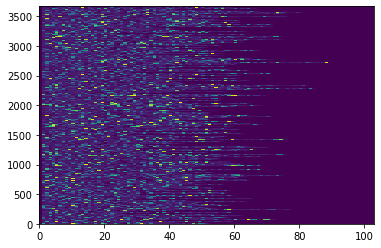

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
print(cls)
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

Now prepend a [CLS] token, and concatenate the ragged tensors to form a single input_word_ids tensor for each example. RaggedTensor.to_tensor() zero pads to the longest sequence.

We can see the CLS token 101 at the start, then we have all the ids at the middleand zero padding ids at the end to make all length same

In [ ]:
print(input_word_ids.to_tensor().shape)
tmp_iwi = input_word_ids.to_tensor()

print(tmp_iwi[0:4,:])

(3668, 103)
tf.Tensor(
[[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
   2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
  21334  2015  1010  3048  2006  2416  7787  1012   102     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  101  2625  2084  2322  3867  1997 23193  1005  1055  4341  2052  2272
   2013  2437 13891  1998  3259  2044  1996  2436 17848  5309  2003  2949
   1012   102  2625  2084  2322  3867  1997 23193  1005  1055  4341  2052
   2272  2013  2437 13891  1998  3259  2044  1996  2436 17848  5309  2003
   3143  1010 10262  2216  5661  4995  1005 

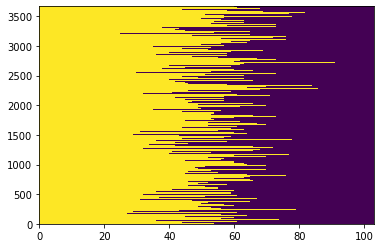

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

What is this doing?

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()



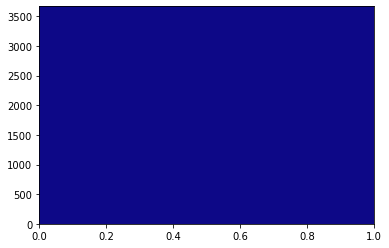

In [ ]:
plt.pcolormesh(type_cls,cmap = "plasma")

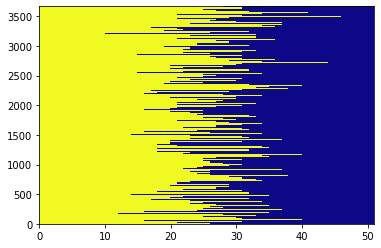

In [ ]:
plt.pcolormesh(tf.ones_like(sentence1).to_tensor(),cmap = "plasma")

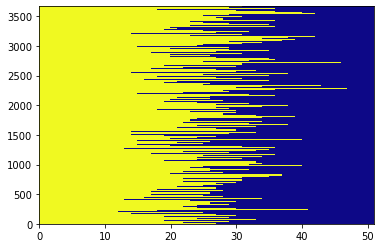

In [ ]:
plt.pcolormesh(type_s2.to_tensor(),cmap = "plasma")

In [ ]:
print(input_type_ids[2:4,:])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(2, 103), dtype=int32)


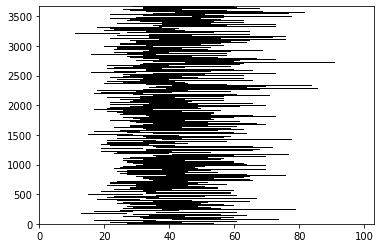

In [ ]:
plt.pcolormesh(input_type_ids,cmap = "binary")

This is just repeated encode_sentence method as of above(don't get confused)



In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  
  #Don't need below for SST2 data as we have only one sentence
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  #Increase lst size of CLS from 1 to length of sentence1/2
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]

  #We may need to change here for SST2 data as we don't have two sentences
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
glue_test.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [ ]:
glue_test["input_type_ids"]

<tf.Tensor: shape=(1725, 104), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

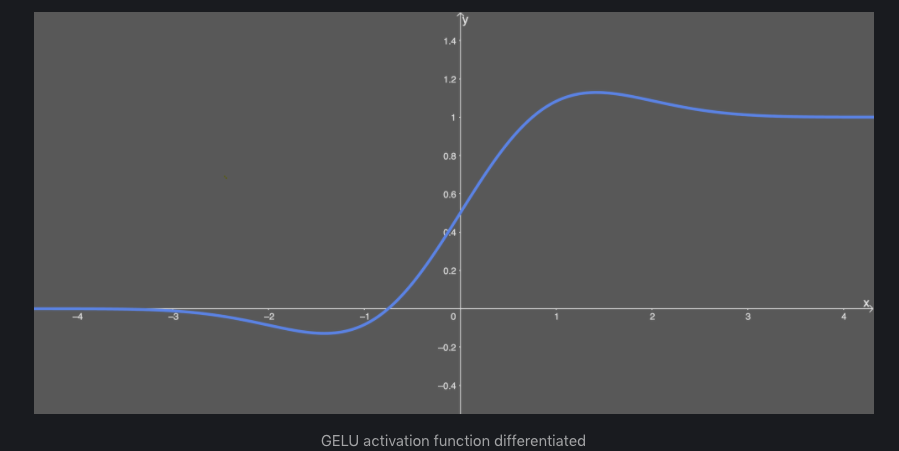

Gelu activation was introdi=ucted in 2016 helps in vanishing gradient problems and especially blemnds well for transformers. A combinaltion if some hyperbolic functions like tanh and sech

If we have more labels(categorical classification and maybe POS tag) then change the number of labels here

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

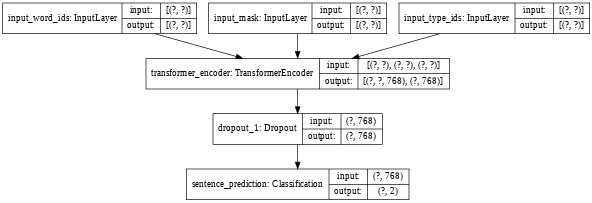

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Testing the waters by forward propping first 10 mrpc datasets sentences through transformers

In [ ]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.02412436,  0.00360811],
       [-0.09358159,  0.0623569 ],
       [ 0.12486266, -0.00710532],
       [ 0.0351173 ,  0.19746545],
       [ 0.1333697 ,  0.10854093],
       [ 0.15708321,  0.07135809],
       [ 0.05616707, -0.10923967],
       [ 0.02609804,  0.00597663],
       [ 0.17377159,  0.15389977],
       [ 0.07027418, -0.06320365]], dtype=float32)

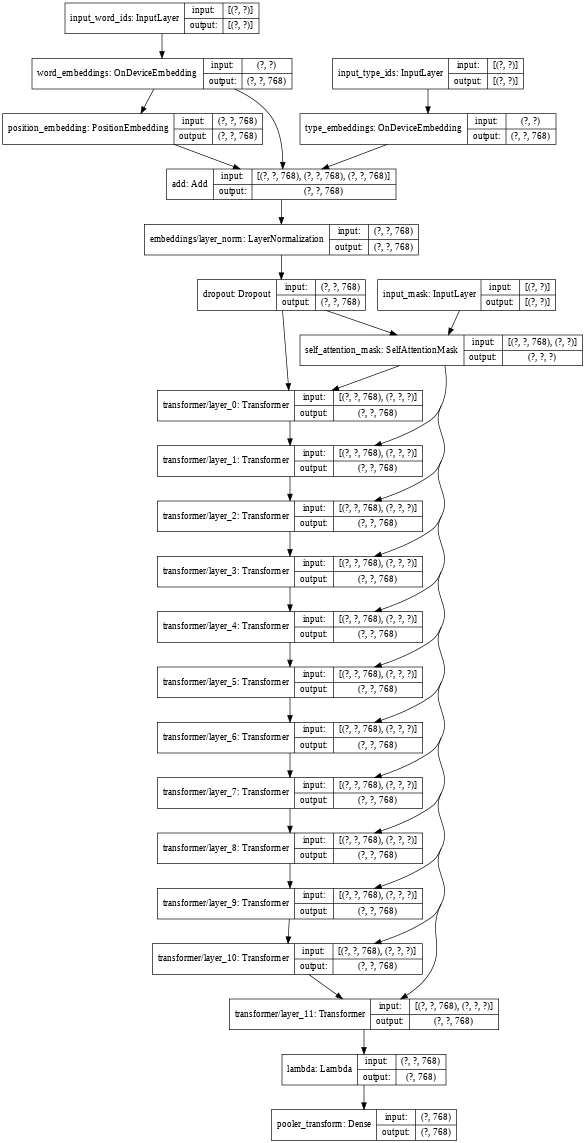

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 155s 1s/step - loss: 0.6405 - accuracy: 0.6629 - val_loss: 0.5185 - val_accuracy: 0.7500
Epoch 2/3
115/115 [==============================] - 139s 1s/step - loss: 0.4710 - accuracy: 0.7965 - val_loss: 0.4095 - val_accuracy: 0.8113
Epoch 3/3
115/115 [==============================] - 139s 1s/step - loss: 0.3056 - accuracy: 0.8933 - val_loss: 0.4013 - val_accuracy: 0.8162


In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.',
            "!What the heck are you doing?",
            "The movie was unique, uniquely shit."],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match ber.',
            "What the hell are you doing",
            "The movie was consistent, consistently crap."]
    },
    tokenizer=tokenizer)

As told in the assignment page, we need to add axis = 1 without which we won't get correct answer**(gives across rows instead of across sentences)**

In [ ]:
result = bert_classifier(my_examples, training=False)
print(result)
result = tf.argmax(result).numpy()
result

tf.Tensor(
[[-1.032946    0.8873828 ]
 [ 0.13587931 -0.29506785]
 [-0.6031818   0.6768846 ]
 [-0.8445115   0.49967706]], shape=(4, 2), dtype=float32)


array([1, 0])

In [ ]:
result = bert_classifier(my_examples, training=False)
print(result)
result = tf.argmax(result, axis = 1).numpy()
result

tf.Tensor(
[[-1.032946    0.8873828 ]
 [ 0.13587931 -0.29506785]
 [-0.6031818   0.6768846 ]
 [-0.8445115   0.49967706]], shape=(4, 2), dtype=float32)


array([1, 0, 1, 1])

In [ ]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent', 'equivalent', 'equivalent'],
      dtype='<U14')

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
!zip -r bert_sentence_similarity_classifier_model.zip /content/saved_model


  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 92%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 76%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


# SST2 data transformers - For Testing(Used higer level abstraction)

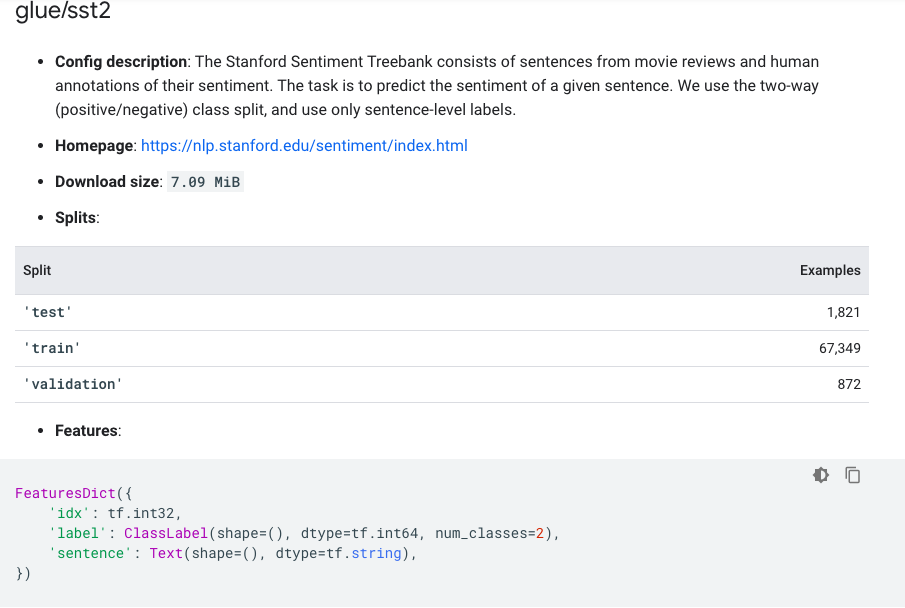

In [ ]:
glue_sst2, info_sst2 = tfds.load('glue/sst2', with_info=True, batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompletePFZUVB/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompletePFZUVB/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompletePFZUVB/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.


In [ ]:
list(glue_sst2.keys())

['test', 'train', 'validation']

In [ ]:
info_sst2.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [ ]:
info_sst2.features['label'].names

['negative', 'positive']

In [ ]:
glue_train_sst2 = glue_sst2['train']
glue_test_sst2 = glue_sst2["test"]
glue_validation_sst2 = glue_sst2["validation"]

for key, value in glue_train.items():
  print(f"{key:9s}: {value[3].numpy()}")

idx      : 17307
label    : 1
sentence : b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "


Vocabulary stays constant even though dataset changes as we are having english reviews not Mandarin or some other language.

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)



In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
sentence = tf.ragged.constant([encode_sentence(s) for s in glue_train_sst2["sentence"]])


In [ ]:
print("Sentence shape:", sentence.shape.as_list())

Sentence shape: [67349, None]


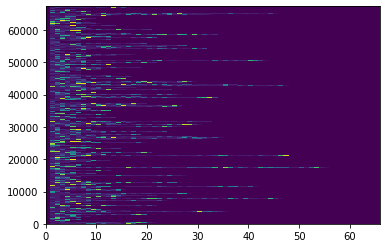

In [ ]:
cls_sst2 = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]

input_word_ids_sst2 = tf.concat([cls_sst2, sentence], axis=-1)

_ = plt.pcolormesh(input_word_ids_sst2.to_tensor())

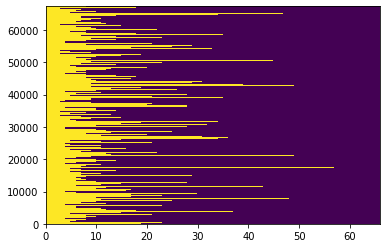

In [ ]:
input_mask_sst2 = tf.ones_like(input_word_ids_sst2).to_tensor()

plt.pcolormesh(input_mask_sst2)

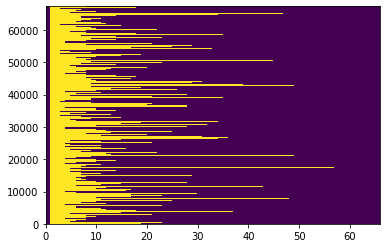

In [ ]:
type_cls_sst2 = tf.zeros_like(cls_sst2)
type_s = tf.ones_like(sentence)

input_type_ids_sst2 = tf.concat([type_cls_sst2, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids_sst2)

In [ ]:

def encode_sentence_sst2(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode_sst2(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence_sst2(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]

  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.ones_like(cls)
  type_s = tf.ones_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs


In [ ]:
glue_train_sst2 = bert_encode_sst2(glue_sst2['train'], tokenizer)
glue_train_sst2_labels = glue_sst2['train']['label']

glue_validation_sst2 = bert_encode_sst2(glue_sst2['validation'], tokenizer)
glue_validation_sst2_labels = glue_sst2['validation']['label']

glue_test_sst2 = bert_encode_sst2(glue_sst2['test'], tokenizer)
glue_test_sst2_labels  = glue_sst2['test']['label']

In [ ]:
for key, value in glue_train_sst2.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_sst2_labels.shape}')

input_word_ids  shape: (67349, 66)
input_mask      shape: (67349, 66)
input_type_ids  shape: (67349, 66)
glue_train_labels shape: (67349,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
glue_batch_sst2 = {key: val[:10] for key, val in glue_train_sst2.items()}

bert_classifier(glue_batch_sst2, training=True).numpy()

array([[ 0.13329169, -0.11979671],
       [ 0.21844661, -0.03019841],
       [ 0.23231071, -0.06961063],
       [ 0.07338411,  0.05414863],
       [ 0.3655791 , -0.08618423],
       [ 0.07139898, -0.12047008],
       [ 0.32631668, -0.10422374],
       [ 0.08241622,  0.08850386],
       [ 0.07363332, -0.0142684 ],
       [ 0.15034994,  0.03869385]], dtype=float32)

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

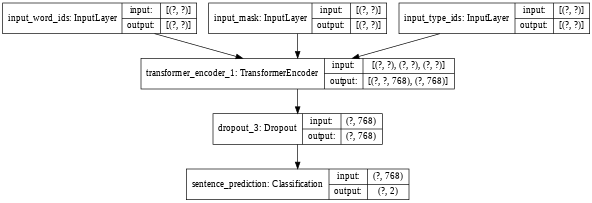

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
glue_batch_sst2 = {key: val[:10] for key, val in glue_train_sst2.items()}

bert_classifier(
    glue_batch_sst2, training=True
).numpy()

array([[-0.09874091,  0.37971368],
       [-0.1994424 ,  0.51934296],
       [-0.0297375 ,  0.12908526],
       [-0.23186666,  0.38288194],
       [ 0.0012027 ,  0.4720629 ],
       [ 0.02461315,  0.37804434],
       [-0.37308824,  0.4951066 ],
       [-0.19299322,  0.47721907],
       [-0.3990406 ,  0.4820495 ],
       [-0.25461993,  0.27948502]], dtype=float32)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_sst2_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train_sst2, glue_train_sst2_labels,
      validation_data=(glue_validation_sst2, glue_validation_sst2_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
2105/2105 [==============================] - 1696s 806ms/step - loss: 0.3781 - accuracy: 0.8104 - val_loss: 0.2251 - val_accuracy: 0.9186
Epoch 2/3
2105/2105 [==============================] - 1681s 799ms/step - loss: 0.1092 - accuracy: 0.9615 - val_loss: 0.2418 - val_accuracy: 0.9174
Epoch 3/3
2105/2105 [==============================] - 1681s 799ms/step - loss: 0.0665 - accuracy: 0.9789 - val_loss: 0.2671 - val_accuracy: 0.9232


steve justin biebere

In [ ]:
my_examples_sst2 = bert_encode_sst2(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.', 'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples_sst2, training=False)

result = tf.argmax(result, axis = 1).numpy()
result

array([0, 1, 1, 0])

In [ ]:
np.array(info.features['label'].names)[result]

array(['not_equivalent', 'equivalent', 'equivalent', 'not_equivalent'],
      dtype='<U14')

In [ ]:
export_dir='./saved_model_bert_sst2'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model_bert_sst2/assets


INFO:tensorflow:Assets written to: ./saved_model_bert_sst2/assets


In [ ]:
!zip -r bert_sst2_sentiment_classifier_model.zip /content/saved_model_bert_sst2

  adding: content/saved_model_bert_sst2/ (stored 0%)
  adding: content/saved_model_bert_sst2/assets/ (stored 0%)
  adding: content/saved_model_bert_sst2/saved_model.pb (deflated 93%)
  adding: content/saved_model_bert_sst2/variables/ (stored 0%)
  adding: content/saved_model_bert_sst2/variables/variables.index (deflated 76%)
  adding: content/saved_model_bert_sst2/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
# Build the rest of the classifier 
dense = tf.keras.layers.Dense(256, activation='gelu')
pred = tf.keras.layers.Dense(1, activation='sigmoid')

# Cola BERT Model (Manual attachment of encoder and classifier)

**Summary**

1. Load the pretrained encoder from tf hub and restore its weights from checkpoints. If you change the architecture like key and value sizes etc, you may need to pretrain model from scratch else weights can be restored.

2. Download and preprocess the input dataset, During preprocessing use punctuation, space and wordpiece tokenizer. 

3. Download the pretrained vocabulary file which has word id to token mapping. This also has unknown tokens, special symbols etc. For chinese or non-english charatcers download separate vocabulary. 

4. You can also pretrain the vocabulary or make your own vocabulary file based on your domain and language.

5. BPT tokenizer will split each word to separate tokens greedily, Add ## to let know that this token is a part of another word and not a word in itself. Each token is assigned a word id according to the vocabulary

6. During encoding apply two types of masks, one to know where sequence stops and padding starts and another to differentiate between the sentences in the paddings(two sentence similarity classifier). 

7. Theoretically we may still need mask to know where input sequence stops and padding starts and we can don't need input_word_ids mask for single sentences, but when tried to encode this way we will get failure due to the architecture. So we need to include the mask.

8. Create a manual classifier wrapping the transformer encoder, which has linear layer with vocab size as output options.

9. Pretrain the entire architecture where transformer weights would be tuned very finely (much smaller than pretraining) and also classifier.

10. Test on our random data


In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [6]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteOKN1KI/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteOKN1KI/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteOKN1KI/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [9]:
info.features['label'].names

['unacceptable', 'acceptable']

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

In [15]:
print("Sentence shape:", sentence.shape.as_list())


Sentence shape: [8551, None]


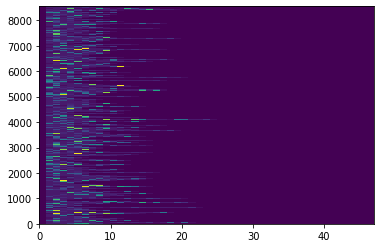

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
input_word_ids = tf.concat([cls, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())


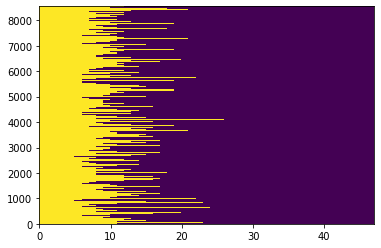

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

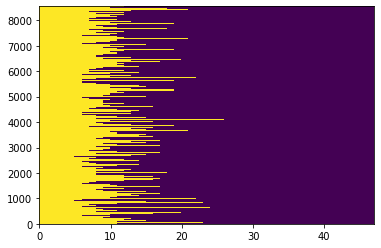

In [19]:
type_cls = tf.ones_like(cls)
type_s = tf.ones_like(sentence)
input_type_ids = tf.concat([type_cls, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [50]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  
  type_cls = tf.ones_like(cls)
  type_s = tf.ones_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()
  
  
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [43]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [44]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 47)
input_mask      shape: (8551, 47)
input_type_ids  shape: (8551, 47)
glue_train_labels shape: (8551,)


In [24]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [25]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'activation': <function official.modeling.activations.gelu.gelu>,
 'attention_dropout_rate': 0.1,
 'dropout_rate': 0.1,
 'hidden_size': 768,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f806dfec208>,
 'intermediate_size': 3072,
 'max_sequence_length': 512,
 'num_attention_heads': 12,
 'num_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

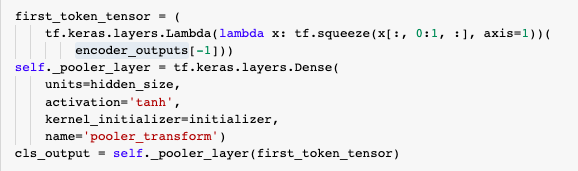

**It seems like The lambda layer is extracting information from last encoder layer output. Also it seems like it being picked from a single attention head 0:1 slicing.**

**The pooler layer is just a dense layer with Tanh activation on embedding from lambda layer.** **bold text**

In [26]:
manual_encoder = nlp.modeling.networks.TransformerEncoder(**transformer_config)

In [27]:
checkpoint = tf.train.Checkpoint(model=manual_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [110]:
manual_encoder.trainable_weights[21]

<tf.Variable 'transformer/layer_1/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.03111691, -0.01362056, -0.07754646, ..., -0.04953363,
         -0.01315064,  0.00493741],
        [ 0.02049251,  0.04187879, -0.02212523, ...,  0.05867812,
          0.15358211,  0.02076852],
        [ 0.12322471,  0.03100824, -0.03068102, ..., -0.00852323,
          0.05456061, -0.04423812],
        ...,
        [-0.05035662,  0.02771335, -0.03543352, ...,  0.02434521,
          0.06291904, -0.06429093],
        [ 0.03714303, -0.01758298,  0.01077895, ..., -0.02780365,
          0.04491649, -0.02780394],
        [ 0.00094853, -0.0263502 , -0.06482668, ...,  0.05963622,
          0.00648222, -0.01244497]],

       [[-0.02652482, -0.02519243, -0.05023147, ..., -0.04022506,
         -0.07214471, -0.0311933 ],
        [-0.01719973, -0.01337474, -0.02746766, ...,  0.04178743,
          0.00329675,  0.03051708],
        [ 0.02388339,  0.09261566,  0.04020307, ..., -0.114528

In [129]:
tme = manual_encoder.trainable_weights[21][:, 9, :]

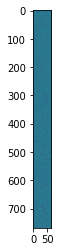

In [130]:
plt.imshow(tme )

In [48]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.']},
    tokenizer=tokenizer)

In [49]:
result = manual_encoder(my_examples, training=False)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

AssertionError: ignored

In [51]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'I saw that gas can explode.']},
    tokenizer=tokenizer)

In [54]:
len(result)

2

In [52]:
result = manual_encoder(my_examples, training=False)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 12, 768)
Pooled output shape: (2, 768)


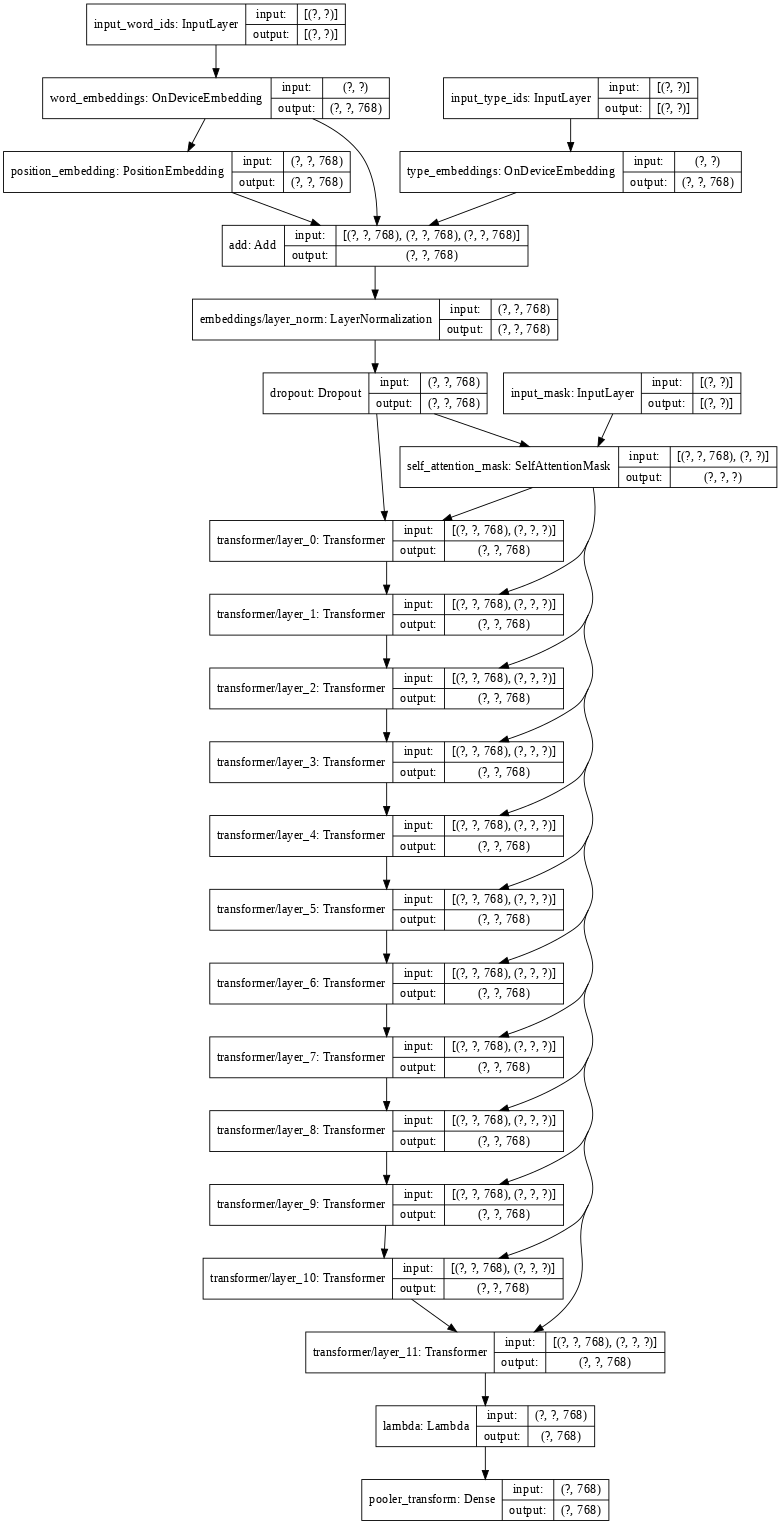

In [132]:
tf.keras.utils.plot_model(manual_encoder, show_shapes=True, dpi=64)


In [56]:
manual_classifier = nlp.modeling.models.BertClassifier(
        manual_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [57]:
manual_classifier(my_examples, training=True).numpy()

array([[-0.52409387,  0.31285107],
       [-0.30057865,  0.38749963]], dtype=float32)

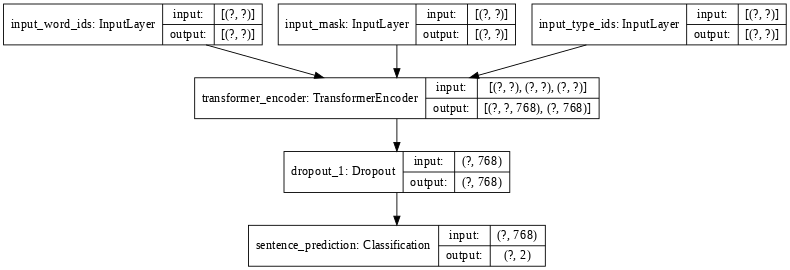

In [133]:
tf.keras.utils.plot_model(manual_classifier, show_shapes=True, dpi=64)

In [60]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [61]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [62]:
epochs = 5
batch_size = 32
eval_batch_size = 16

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

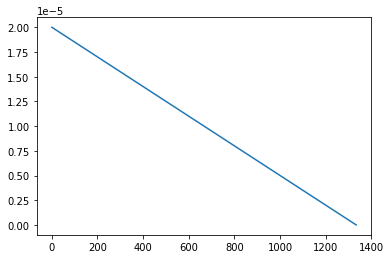

In [63]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

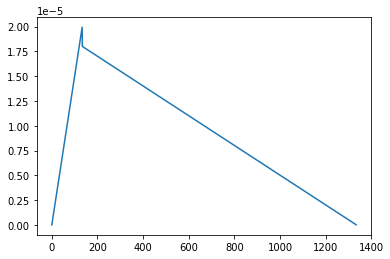

In [64]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# The warmup overshoots, because it warms up to the `initial_learning_rate`
# following the original implementation. You can set
# `initial_learning_rate=decay_schedule(warmup_steps)` if you don't like the
# overshoot.
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

In [66]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [67]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

manual_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

manual_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/5
268/268 [==============================] - 107s 399ms/step - loss: 0.5813 - accuracy: 0.7197 - val_loss: 0.4324 - val_accuracy: 0.8130
Epoch 2/5
268/268 [==============================] - 95s 356ms/step - loss: 0.3415 - accuracy: 0.8566 - val_loss: 0.4814 - val_accuracy: 0.7977
Epoch 3/5
268/268 [==============================] - 95s 354ms/step - loss: 0.1913 - accuracy: 0.9335 - val_loss: 0.5046 - val_accuracy: 0.8284
Epoch 4/5
268/268 [==============================] - 95s 354ms/step - loss: 0.1165 - accuracy: 0.9619 - val_loss: 0.5644 - val_accuracy: 0.8341
Epoch 5/5
268/268 [==============================] - 95s 354ms/step - loss: 0.0903 - accuracy: 0.9711 - val_loss: 0.5926 - val_accuracy: 0.8437


Corpus Sample


clc95	0	*	In which way is Sandy very anxious to see if the students will be able to solve the homework problem?

c-05	1		The book was written by John.

c-05	0	*	Books were sent to each other by the students.

swb04	1		She voted for herself.

swb04	1		I saw that gas can explode.

In [71]:
info.features['label'].names

['unacceptable', 'acceptable']

In [77]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'I saw that gas can explode.', "What's the time now?", "I can make do without mayo.",
            "I saw that gas can explode.", "She voted for herself.", "Books were sent to each other by the students.", "The book was written by John.",
            "In which way is Sandy very anxious to see if the students will be able to solve the homework problem?", "In jungle the lived tarzan a."]},
    tokenizer=tokenizer)

In [78]:
results = manual_classifier(my_examples, training=False).numpy()
results

array([[-2.0503287,  2.2647827],
       [-2.2913558,  2.4469733],
       [-2.3154979,  2.40252  ],
       [-2.322591 ,  2.671986 ],
       [-2.2913558,  2.4469733],
       [-2.0857754,  2.4675007],
       [-2.5427437,  2.9134598],
       [-2.3438401,  2.9095745],
       [-1.7903519,  1.9692929],
       [ 1.595684 , -1.8879359]], dtype=float32)

In [79]:
results = tf.argmax(results, axis = 1).numpy()
results

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [81]:
export_dir='./saved_model_bert_cola'
tf.saved_model.save(manual_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model_bert_cola/assets


INFO:tensorflow:Assets written to: ./saved_model_bert_cola/assets


In [82]:
!zip -r saved_model_bert_cola.zip /content/saved_model_bert_cola/

  adding: content/saved_model_bert_cola/ (stored 0%)
  adding: content/saved_model_bert_cola/saved_model.pb (deflated 93%)
  adding: content/saved_model_bert_cola/variables/ (stored 0%)
  adding: content/saved_model_bert_cola/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model_bert_cola/variables/variables.index (deflated 76%)
  adding: content/saved_model_bert_cola/assets/ (stored 0%)
